In [1]:
using FFMPEG

┌ Info: Precompiling FFMPEG [c87230d0-a227-11e9-1b43-d7ebe4e7570a]
└ @ Base loading.jl:1273


In [2]:
using PyPlot,JLD2,Statistics,PyCall
# rc("font",family="serif")
# include("CGS.jl")

In [3]:
matplotlib.animation = pyimport("matplotlib.animation")

PyObject <module 'matplotlib.animation' from '/Users/bethleelindor/.julia/conda/3/lib/python3.7/site-packages/matplotlib/animation.py'>

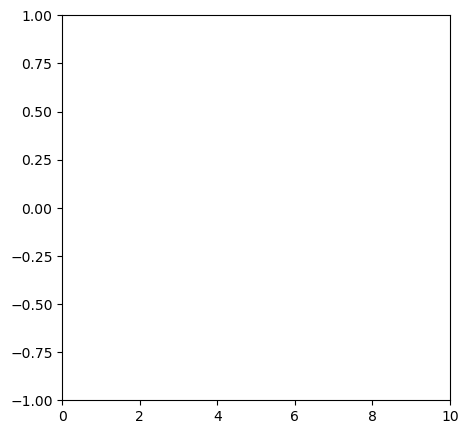

PyObject <matplotlib.animation.FuncAnimation object at 0x143814eb8>

In [24]:
function simData()
    t_max = 10.0
    dt = 0.05
    x = 0.0
    t = -dt

    function it()
        while t < t_max
            x = sin(pi * t)
            t = t + dt
            produce(x, t)
        end
    end

    Task(it)
end

function simPoints()
    task = simData()

    function points(frame_number)
        x, t = consume(task)
        line.set_data(t, x)
        return(line, "")
    end

    points
end

fig = figure(figsize=(5,5))
axis = fig.add_subplot(111)
line = axis.plot([], [], "bo", ms = 10)[1]
axis.set_ylim(-1, 1)
axis.set_xlim(0, 10)

ani = matplotlib.animation.FuncAnimation(fig, simPoints(), blit=false, interval=10, frames=200, repeat=false)

In [41]:
myanim.save("test1.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
    
# # Function for creating an embedded video given a filename
# function html_video(filename)
#     open(filename) do f
#         base64_video = base64encode(f)
#         """<video controls src="data:video/x-m4v;base64,$base64_video">"""
#     end
# end

MovieWriter ffmpeg unavailable. Trying to use html instead.


PyCall.PyError: [91mPyError ($(Expr(:escape, :(ccall(#= /Users/bethleelindor/.julia/packages/PyCall/BcTLp/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>[39m
[91mValueError('outfile must be *.htm or *.html')[39m
[91m  File "/Users/bethleelindor/.julia/conda/3/lib/python3.7/site-packages/matplotlib/animation.py", line 1166, in save[39m
[91m    with writer.saving(self._fig, filename, dpi):[39m
[91m  File "/Users/bethleelindor/.julia/conda/3/lib/python3.7/contextlib.py", line 112, in __enter__[39m
[91m    return next(self.gen)[39m
[91m  File "/Users/bethleelindor/.julia/conda/3/lib/python3.7/site-packages/matplotlib/animation.py", line 228, in saving[39m
[91m    self.setup(fig, outfile, dpi, *args, **kwargs)[39m
[91m  File "/Users/bethleelindor/.julia/conda/3/lib/python3.7/site-packages/matplotlib/animation.py", line 857, in setup[39m
[91m    raise ValueError("outfile must be *.htm or *.html")[39m


In [38]:
methods(matplotlib.animation.FuncAnimation.save)

# 1 method:
[1] (o::PyObject)(args...; kwargs...) in PyCall at /Users/bethleelindor/.julia/packages/PyCall/BcTLp/src/pyfncall.jl:86

### Plot of simulated years observed vs TTVs

In [2]:
include("decompose_ttvs.jl")
include("plot_likelihood.jl")
include("corner_plot.jl")
include("plot_ttvs.jl")

plot_ttvs (generic function with 2 methods)

## Posterior Distributions

### Plot masses of Venus and Earth in $M_{\oplus}$

In [ ]:
xvalue = vec(par_mcmc[:,iburn:nsteps,1]).* CGS.MSUN/CGS.MEARTH
yvalue = vec(par_mcmc[:,iburn:nsteps,6]).*CGS.MSUN/CGS.MEARTH
optx = mu_1.* CGS.MSUN/CGS.MEARTH
opty = mu_2.* CGS.MSUN/CGS.MEARTH
truex = 0.815
truey = 1
nbins = 50
corner_plot(xvalue,yvalue,nbins,optx,opty,truex,truey)
xlabel(L"Mass of Venus [$M_{\oplus}$]")
ylabel(L"Mass of Earth [$M_{\oplus}$]")
# savefig("massposteriors.png")

In [6]:
include("corner_plot.jl")
corner_hist(10.0,20.0,"EMB","p3",50)

In [5]:
corner_hist(10.0,20.0,"noEMB","p3",50)

### Plot eccentricities of Venus and Earth

In [ ]:
xvalue = sqrt.(vec(par_mcmc[:,iburn:nsteps,4]).^2 + vec(par_mcmc[:,iburn:nsteps,5]).^2)
yvalue = sqrt.(vec(par_mcmc[:,iburn:nsteps,9]).^2 + vec(par_mcmc[:,iburn:nsteps,10]).^2)
optx = sqrt(e1cosw1^2 + e1sinw1^2)
opty = sqrt(e2cosw2^2 + e2sinw2^2)
truex = 0.00677323
truey = 0.01671022
nbins=50
corner_plot(xvalue,yvalue,nbins,optx,opty,truex,truey)
xlabel("Eccentricity of Venus")
ylabel("Eccentricity of Earth")
# savefig("eccposteriors.png")

### Plot periods of Venus and Earth?

In [ ]:
xvalue = vec(par_mcmc[:,iburn:nsteps,2])
yvalue = vec(par_mcmc[:,iburn:nsteps,7]) 
optx = P_1
opty = P_2
truex = 225
truey = 365
nbins=50
corner_plot(xvalue, yvalue, nbins, optx, opty, truex, truey)
xlabel(L"Period of Venus [$days$]")
ylabel(L"Period of Earth [$days$]")


In [ ]:
10 .^ range(log10(10.6),stop=log10(14.2),length=200)

### Plot mass of Jupiter $M_{Jup}$ vs its eccentricity

In [ ]:
xvalue = vec(par_mcmc[:,iburn:nsteps,11]).* CGS.MSUN/CGS.MJUPITER
yvalue = sqrt.(vec(par_mcmc[:,iburn:nsteps,14]).^2 + vec(par_mcmc[:,iburn:nsteps,15]).^2)
optx = mu_3.* CGS.MSUN/CGS.MJUPITER
opty = sqrt(e3cosw3^2 + e3sinw3^2)
truex = 1
truey = 0.04839266
nbins=50
corner_plot(xvalue, yvalue, nbins, optx, opty, truex, truey)
xlabel(L"Mass of Jupiter [$M_{Jup}$]")
ylabel("Eccentricity of Jupiter")
# savefig("jupiterposteriors.png")

### Plot time of inferior conjuction [JD - 24550000] $t_{03}$ vs Jupiter period $P_3$. 

In [ ]:
xvalue = vec(par_mcmc[:,iburn:nsteps,12])
yvalue = vec(par_mcmc[:,iburn:nsteps,13]) .- 2.443e6
optx = P_3
opty = t03 .- 2.443e6
# truex = 1
# truey = 0.04839266
nbins=50
corner_plot(xvalue, yvalue, nbins, optx, opty, truex, truey)
xlabel(L"Period of Jupiter [$days$]")
ylabel(L"$t_{0}$ of Jupiter")

### Plot TTV of Earth due to Moon $t_{max}$ vs phase change of Moon per Earth year $\Delta \phi$

In [ ]:
# function plot_posterior(samples,bins,range)
# tmax = vec(sqrt(par_mcmc[:,iburn:nsteps,16]).^2 + vec(par_mcmc[:,iburn:nsteps,17]).^2)
xvalue = sqrt.(vec(par_mcmc[:,iburn:nsteps,16].^2) + vec(par_mcmc[:,iburn:nsteps,17].^2)).* (24 * 60)
yvalue = vec(par_mcmc[:,iburn:nsteps,18]).* 57.2957795 
optx = sqrt(param[16]^2 + param[17]^2).* (24 * 60)
opty = param[18].* 57.2957795 
# truex = 
truey = 2.3122 .* 57.2957795 
meanx=mean(xvalue);sigmax=std(xvalue)
meany=mean(yvalue);sigmay=std(yvalue)
nbins=50
corner_plot(xvalue,yvalue,nbins,optx,opty,truex,truey)
xlabel("Amplitude of Moon [min]")
ylabel("Phase Change of Moon [deg]")
# savefig("moonposteriors.png")

### Plot longitude of ascending node $\Omega$ vs longitude of pericenter $\bar \omega$; with argument of pericenter $\omega$

In [245]:
g=jldopen("FITS/fromEMB/p3_fit30.0s30.0yrs.jld2","r")
tt,tt0,sigtt,ttmodel = g["tt"],g["tt0"],g["sigtt"],g["ttmodel"]
pbest_global = g["best_p3"]
nplanet,ntrans = g["nplanet"],g["ntrans"]
# pair_ttvs = decompose_ttvs(nplanet,ntrans,pbest_global) .* (24 * 60)
n1,n2,n3 = ntrans
mu1,P1,t01,ecosw1,esinw1 = pbest_global[1:5]
mu2,P2,t02,ecosw2,esinw2 = pbest_global[6:10]
mu3,P3,t03,ecosw3,esinw3 = pbest_global[11:15]
# time1 = collect(t01 .+ range(0,stop=n1-1,length=n1) .* P1)
# time2 = collect(t02 .+ range(0,stop=n2-1,length=n2) .* P2)
tt1,tt01 = tt[1:n1],tt0[1:n1]
tt2,tt02 = tt[n1+1:n1+n2],tt0[n1+1:n1+n2]

([2.433624404896996e6, 2.433989659571913e6, 2.4343549169757506e6, 2.434720170198379e6, 2.4350854290913274e6, 2.435450686189174e6, 2.435815938772034e6, 2.436181195351934e6, 2.436546452039964e6, 2.4369117088691522e6  …  2.441294789551072e6, 2.441660044224819e6, 2.4420253037346653e6, 2.4423905602110857e6, 2.4427558136647013e6, 2.443121070883718e6, 2.4434863245670246e6, 2.4438515822939654e6, 2.4442168407435166e6, 2.4445820922158603e6], [2.433624402638408e6, 2.433989659065065e6, 2.434354915491722e6, 2.434720171918379e6, 2.435085428345036e6, 2.4354506847716933e6, 2.435815941198351e6, 2.436181197625008e6, 2.436546454051665e6, 2.436911710478322e6  …  2.4412947875982076e6, 2.4416600440248647e6, 2.4420253004515218e6, 2.442390556878179e6, 2.442755813304836e6, 2.443121069731493e6, 2.44348632615815e6, 2.4438515825848076e6, 2.4442168390114647e6, 2.444582095438122e6])

In [258]:
J2000 = 2451545.0
jd1=2.4332825e6
calc_rad(value) = value * pi/180
calc_deg(value) = value * 180/pi
calc_omega(pomega,Omega) = pomega - Omega
calc_M(t,t0,P)=2pi .* (t.-t0) ./ P

calc_M (generic function with 1 method)

Agol & Deck 2015 equation 5 for mean longitude

In [163]:
function calc_L(t,t0,P,esinw)
    lambda = ((360/P) .* (t.-t0)) .+ 2*esinw
    return lambda
end

calc_L (generic function with 1 method)

In [133]:
P1/365.25,P2/365.25,P3/365.25

(0.6151971978957823, 1.000017663879583, 11.597325781312636)

In [246]:
e1 = sqrt.(ecosw1.^2 + esinw1.^2)
e2 = sqrt.(ecosw2.^2 + esinw2.^2)
e3 = sqrt.(ecosw3.^2 + esinw3.^2)
e1,e2,e3

(0.007552295476634351, 0.01466059740501133, 0.0454727262813164)

We assume an edge-on, plane-parallel system with the $\Omega = 0$ such that $\omega = \varpi$

In [247]:
w1 = calc_deg(atan(esinw1,ecosw1))
w2 = calc_deg(atan(esinw2,ecosw2))
w3 = calc_deg(atan(esinw3,ecosw3))
w1,w2,w3

(110.24093749596905, 34.5333600284138, -69.08910379986942)

$L \equiv \lambda$. Check to see if $\lambda_{E} \sim \lambda_{V}$ at their respective transit times. $\lambda mod 2 \pi = \lambda_{obs}$[what?] where $\lambda_{obs}$ is longitude that both Earth and Venus have.

In [273]:
L_1 = calc_L(tt1,t01,P1,esinw1)
L_2 = calc_L(tt2,t02,P2,esinw2)
L_1,L_2
# for i=1:length(tt2)
#     println(L_1[i]," ",L_2[i])
# end

([0.012371787476397042, 360.0133343565473, 720.0169824870229, 1080.0135526690897, 1440.0122255198048, 1800.0170057665478, 2160.0177544631683, 2520.01589496752, 2880.0098961630033, 3240.010708947574  …  14040.012713830656, 14400.014083406671, 14760.016677415953, 15120.013983489262, 15480.011012335533, 15840.016055447844, 16200.017730867143, 16560.01607892639, 16920.011100616346, 17280.00925384235], [0.0193074189826956, 360.01755401405876, 720.0184902573101, 1080.015305463873, 1440.017709387891, 1800.0183440440064, 2160.0145286887832, 2520.0146528520695, 2880.014883589056, 3240.0152534528497  …  7560.018441732332, 7920.0166871745005, 8280.01969911849, 8640.01972129125, 9000.016764160737, 9360.017518242807, 9720.014787497934, 10080.016042194638, 10440.018009102552, 10800.01309921289])

In [248]:
L_1.+w1,L_2.+w2#,L_3.+w3

([110.23441005698854, 470.2353371876402, 830.2388169261313, 1190.2355142877648, 1550.2334225068087, 1910.2392921671903, 2270.2397960284884, 2630.2377110567327, 2990.232755940259, 3350.232222648511  …  14150.234538806002, 14510.235477996555, 14870.238889408038, 15230.235784719922, 15590.233067660847, 15950.238464156784, 16310.239487117586, 16670.237586353087, 17030.233029423012, 17390.23145479437], [34.537352959732864, 394.53369807432495, 754.5375676629656, 1114.5321719224687, 1474.5349057276383, 1834.5375357509597, 2194.530177307468, 2554.5326940934497, 2914.533180203558, 3274.531020179454  …  7594.537901329611, 7954.533481497117, 8314.536540632798, 8674.53882086993, 9034.532613647943, 9394.535745181794, 9754.533393802163, 10114.532368817097, 10474.537012190096, 10834.530400168693])

Venus transit occurs 0.277 radians after it goes through periastron. Earth transit occurs -0.552 radians after it goes through periastron. 

In [105]:
calc_deg(0.277),calc_deg(-0.552)

(15.870930925123806, -31.627270291221446)

true $\lambda$ from planet body data sheet: 181.9, 100, 34 degrees ##181.97973, 100.46435, 34.40438

In [218]:
calc_L(jd1,t01,P1,esinw1),calc_L(jd1,t02,P2,esinw2)

(-354.506249963048, -336.98621027107424)

In [238]:
calc_L(J2000,t01,P1,esinw1),calc_L(J2000,t02,P2,esinw2)# L_3 = calc_L(tt3,J2000,P3,esinw3)

(28904.40466370642, 17662.69590703417)

In [263]:
(((360/P1) .* (t01 .- J2000)) .+ 181.97909950)

-28722.4353440571

In [235]:
(((360/P2) .* (t02 .- J2000)) .+ 100.46457166)

-17562.230413677655

In [209]:
28904.428615380195 -28722.4353440571, 17662.716756770507-17562.235563336195

(181.99327132309554, 100.48119343431244)

Calculate angular diffence between J2000 and time of periastron passage

In [266]:
M1,M2,M3=360*(J2000-t01)/P1 , 360*(J2000-t02)/P2 , 360*(J2000-t03)/P3

(28904.4144435571, 17662.700134996194, 1070.4307553559763)

In [37]:
true_w1 = 131.60246718 - 0.00268329*.5
true_w2 = 102.94719 - 0.32327364*.5
# true_w3 = 14.72847983 - 0.21252668*.5
true_w1,true_w2#,true_w3

(131.601125535, 102.78555318000001)

Calculate lunar phase offset, $\Delta\phi= (P_p/P_s - round(P_p/P_s))*2\pi$ 

In [191]:
calc_dphi(P_p,P_s) = (P_p/P_s - round(P_p/P_s))*2pi

calc_dphi (generic function with 1 method)

In [192]:
dphi=calc_dphi(365.256355,27.322)
println(dphi," rad or ",calc_deg(dphi)," degrees")

2.315859255328402 rad or 132.68896127662714 degrees


To calculate moon amplitude, use $t_{max} = \frac{M_s a_s P_p}{(M_s + M_p) 2\pi a_p}$ based on velocity of EMB about Sun

## 10 second noise

In [ ]:
f = extract_data("OUTPUTS/moon_fitmtry2params.jld2")

In [ ]:
@load("mcmc_mtryresults.jld2")

In [ ]:
mu_1,P_1,t01,e1cosw1,e1sinw1,
mu_2,P_2,t02,e2cosw2,e2sinw2,
mu_3,P_3,t03,e3cosw3,e3sinw3,
tmaxsinphi0,tmaxcosphi0,deltaphi = f["pbest_global"]

In [ ]:
w1 = calc_deg(atan(e1sinw1,e1cosw1))
w2 = calc_deg(atan(e2sinw2,e2cosw2))
w3 = calc_deg(atan(e3sinw3,e3cosw3))
w1,w2,w3

In [ ]:
L_1 = calc_L(tt1,tt01,P_1,e1sinw1)
L_2 = calc_L(tt2,tt02,P_2,e2sinw2)
L_1,L_2

In [228]:
(((360/P1) .* (tt01 .- J2000)) .+ 181.97909950) 

49-element Array{Float64,1}:
 -27642.43014947823 
 -27282.430158204912
 -26922.43016693159 
 -26562.430175659018
 -26202.430184385696
 -25842.430193112374
 -25482.430201839055
 -25122.43021056648 
 -24762.43021929316 
 -24402.43022801984 
 -24042.43023674652 
 -23682.430245473945
 -23322.430254200626
      ⋮             
 -14322.430472371347
 -13962.430481098772
 -13602.430489825452
 -13242.430498552132
 -12882.430507278812
 -12522.430516006238
 -12162.430524732918
 -11802.430533459597
 -11442.430542186275
 -11082.430550913703
 -10722.430559640381
 -10362.430568367061

In [ ]:
((360/P_2) .* (tt02 .- J2000) .+ 100.46457166)

In [ ]:
[(360/P_3) .* (t03 .- J2000) .+ 34.39644051,
(360/P_3) .* (t03 .- J2000) .+ 34.39644051 + 360*1,
(360/P_3) .* (t03 .- J2000) .+ 34.39644051 + 360*2]

[Can't recall how i found this]

In [ ]:
77.56936298207381+w1,77.76976911511983+w2,77.91649744476126+w3

In [ ]:
xvalue = calc_deg.(atan.(vec(par_mcmc[:,iburn:nsteps,5]),vec(par_mcmc[:,iburn:nsteps,4]))) .+ 77.6
yvalue = calc_deg.(atan.(vec(par_mcmc[:,iburn:nsteps,10]),vec(par_mcmc[:,iburn:nsteps,9]))) .+ 77.8
optx = calc_deg(atan(e1sinw1,e1cosw1)) + 77.6
opty = calc_deg(atan(e2sinw2,e2cosw2)) + 77.8
truex = 131.601125535
truey = 102.78555318000001
meanx=mean(xvalue);sigmax=std(xvalue)
meany=mean(yvalue);sigmay=std(yvalue)
nbins=50
corner_plot(xvalue,yvalue,nbins,optx,opty,truex,truey)
xlabel(L"Longitude $\varpi$ of Venus [$deg$]")
ylabel(L"Longitude $\varpi$ of Earth [$deg$]")

In [ ]:
xvalue = calc_deg.(atan.(vec(par_mcmc[:,iburn:nsteps,15]),vec(par_mcmc[:,iburn:nsteps,14]))) .+ 77.9
yvalue = calc_deg.(atan.(vec(par_mcmc[:,iburn:nsteps,10]),vec(par_mcmc[:,iburn:nsteps,9]))) .+ 77.8
optx = calc_deg(atan(e3sinw3,e3cosw3)) + 77.9
opty = calc_deg(atan(e2sinw2,e2cosw2)) + 77.8
truex = 14.62221649
truey = 102.78555318000001
nbins=50
corner_plot(xvalue,yvalue,nbins,optx,opty,truex,truey)
xlabel(L"Longitude $\varpi$ of Jupiter [$deg$]")
ylabel(L"Longitude $\varpi$ of Earth [$deg$]")

In [ ]:
(360/P_3 * (t03 - J2000) - 34.39644051)

In [ ]:
corner_planet(vec(par_mcmc[:,iburn:nsteps,6]).* CGS.MSUN/CGS.MEARTH,
    vec(par_mcmc[:,iburn:nsteps,9]),
    vec(par_mcmc[:,iburn:nsteps,10]),
    vec(par_mcmc[:,iburn:nsteps,7]),
0.815,-0.004,-0.002,224.5)

In [ ]:
corner_planet(vec(par_mcmc[:,iburn:nsteps,11]).* CGS.MSUN/CGS.MEARTH,
    vec(par_mcmc[:,iburn:nsteps,14]),
    vec(par_mcmc[:,iburn:nsteps,15]),
    vec(par_mcmc[:,iburn:nsteps,12])
318,-0.004,-0.002,224.5)